# Import Libraries and Load Data

In [1]:
# pip install medmnist

In [47]:
import medmnist
from medmnist import INFO, BloodMNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import cv2
from skimage import morphology, measure
from skimage.color import rgb2gray
import random

In [22]:
# Load the BloodMNIST dataset with high resolution for all splits
train_data = BloodMNIST(split='train', download=True, as_rgb=True, size=224)
val_data = BloodMNIST(split='val', download=True, as_rgb=True, size=224)
test_data = BloodMNIST(split='test', download=True, as_rgb=True, size=224)

Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz


# See Class Distribution

In [23]:
train_data

Dataset BloodMNIST of size 224 (bloodmnist_224)
    Number of datapoints: 11959
    Root location: /Users/lowi33/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'Immature Granulocytes', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0

In [24]:
# Get dataset information
blood_info = INFO['bloodmnist']
n_classes_blood = len(blood_info['label'])

# Get the class labels
class_labels_blood = blood_info['label']
class_labels_blood['3'] = 'Immature Granulocytes'

# Count the number of instances for each class in BloodMNIST
label_counts_blood = Counter([int(label) for _, label in train_data])

In [25]:
# Print the distribution of class labels for BloodMNIST
print("\nClass Label Distribution in BloodMNIST:")
for key, count in label_counts_blood.items():
    print(f"Class {key}: {count} instances")


Class Label Distribution in BloodMNIST:
Class 7: 1643 instances
Class 3: 2026 instances
Class 6: 2330 instances
Class 2: 1085 instances
Class 1: 2181 instances
Class 5: 993 instances
Class 0: 852 instances
Class 4: 849 instances


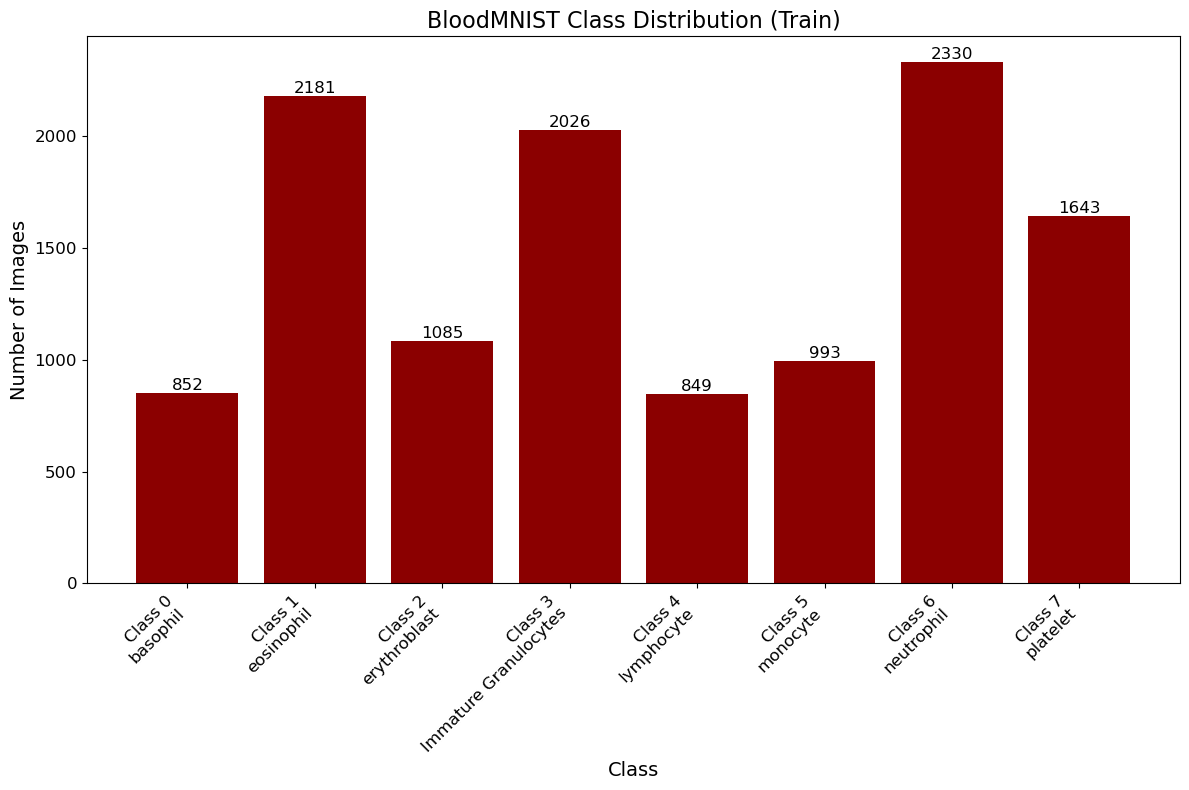

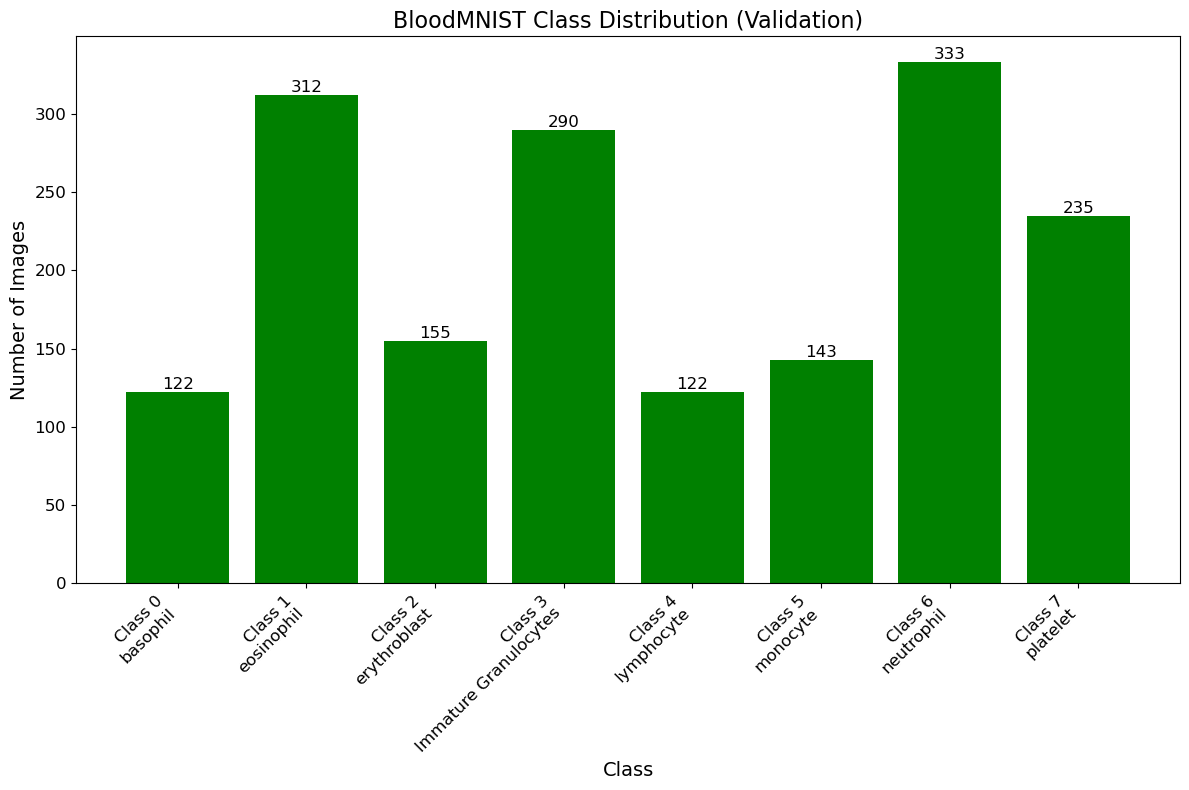

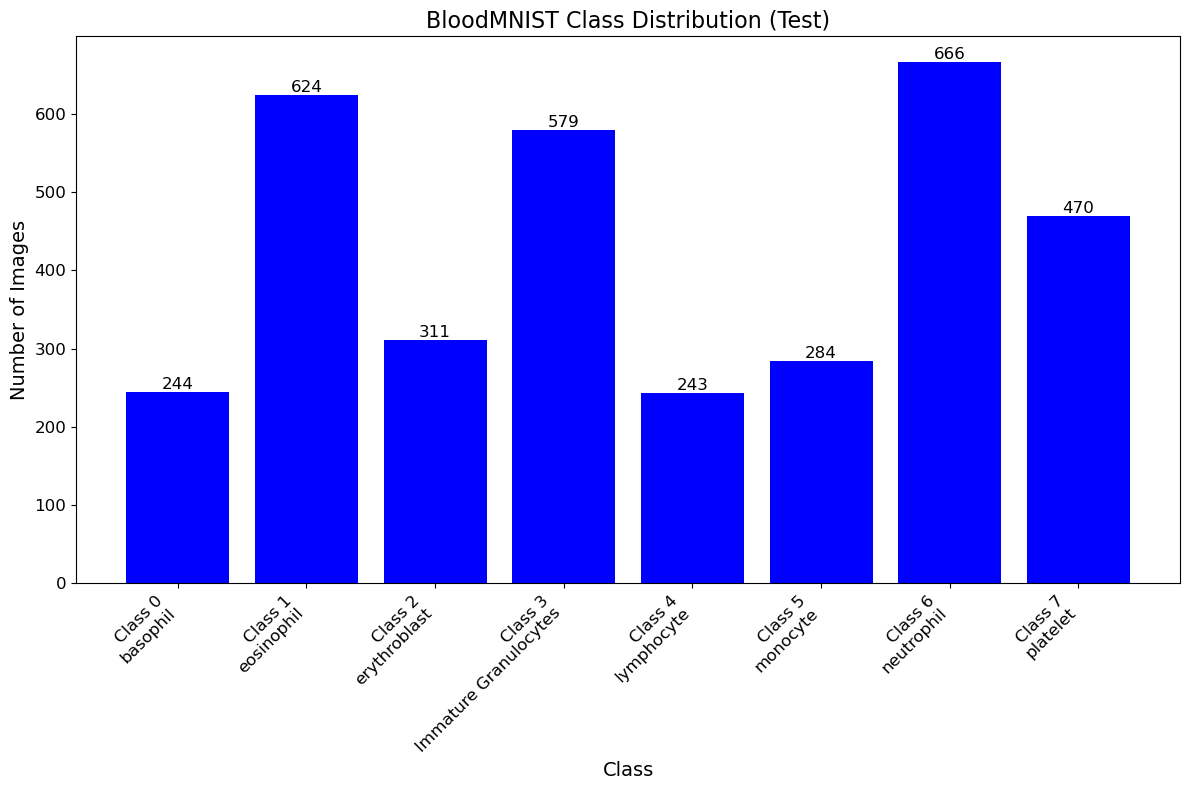

In [26]:
# Count the number of instances for each class in each split
label_counts_train = Counter([int(label) for _, label in train_data])
label_counts_val = Counter([int(label) for _, label in val_data])
label_counts_test = Counter([int(label) for _, label in test_data])

def plot_class_distribution(label_counts, class_labels, title, color):
    classes = list(range(len(class_labels)))  # Ensure all classes are shown
    counts = [label_counts.get(i, 0) for i in classes]
    labels = [f"Class {i}\n{class_labels[str(i)]}" for i in classes]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(classes, counts, tick_label=labels, color=color)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels on top of each column
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot BloodMNIST class distribution
plot_class_distribution(label_counts_train, class_labels_blood, 'BloodMNIST Class Distribution (Train)', 'darkred')
plot_class_distribution(label_counts_val, class_labels_blood, 'BloodMNIST Class Distribution (Validation)', 'green')
plot_class_distribution(label_counts_test, class_labels_blood, 'BloodMNIST Class Distribution (Test)', 'blue')


# Image Preprocessing

- **Binary Thresholding**: Convert images to grayscale and apply a binary threshold to segment the target cells. This step helps in isolating the cells from the background by converting the image to black and white based on a threshold value.

- **Noise Reduction**: Remove small objects from the binary image to focus on the most significant parts of the image (i.e., target cells)

- **Component Labeling**: Label connected components in the binary image and retain the largest connected component, assuming it's the target cell. This step ensures that only the most relevant part of the image is considered.

- **Masking**: Apply the binary mask to the original image to highlight the target cells while suppressing the background and other irrelevant objects.

- **Data Conversion**: Use a class to convert the preprocessed data back to the original data format, which maintains compatibility with PyTorch methods while preserving the data structure for model training and evaluation.


In [27]:
def preprocess_image(image):
    # Convert to grayscale
    gray = rgb2gray(image)
    
    # Apply a binary threshold to segment the target cells
    _, binary = cv2.threshold((gray * 255).astype(np.uint8), 128, 255, cv2.THRESH_BINARY_INV)
    
    # Remove small objects from the binary image
    cleaned = morphology.remove_small_objects(binary > 0, min_size=500)
    
    # Label the connected components
    labeled, num_labels = measure.label(cleaned, return_num=True, connectivity=2)
    
    # Keep the largest connected component (assuming it's the target cell)
    largest_component = morphology.remove_small_objects(labeled, min_size=500)
    
    # Mask the original image
    masked_image = image * np.dstack([largest_component > 0] * 3)
    
    return masked_image

In [28]:
def show_comparison(dataset, n_images=5):
    """Show comparison of original image to preprocessed image"""
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

    for i in range(n_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        preprocessed_img = preprocess_image(np.array(img))

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original Image - Class {int(label)}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(preprocessed_img)
        axes[i, 1].set_title(f"Preprocessed Image - Class {int(label)}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [29]:
def preprocess_dataset(dataset):
    """Pre-process the entire dataset"""
    preprocessed_data = []
    for img, label in dataset:
        preprocessed_img = preprocess_image(np.array(img))
        preprocessed_data.append((preprocessed_img, label))
    return preprocessed_data

# Preprocess and overwrite the datasets
train_data_preprocessed = preprocess_dataset(train_data)
val_data_preprocessed = preprocess_dataset(val_data)
test_data_preprocessed = preprocess_dataset(test_data)


/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_8998/2280269436.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


In [30]:
# Convert preprocessed data back to original data format
class PreprocessedDataset:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        img, label = self.data[index]
        return img, label

    def __len__(self):
        return len(self.data)

# Create dataset objects
train_data_preprocessed = PreprocessedDataset(train_data_preprocessed)
val_data_preprocessed = PreprocessedDataset(val_data_preprocessed)
test_data_preprocessed = PreprocessedDataset(test_data_preprocessed)

# Display Images

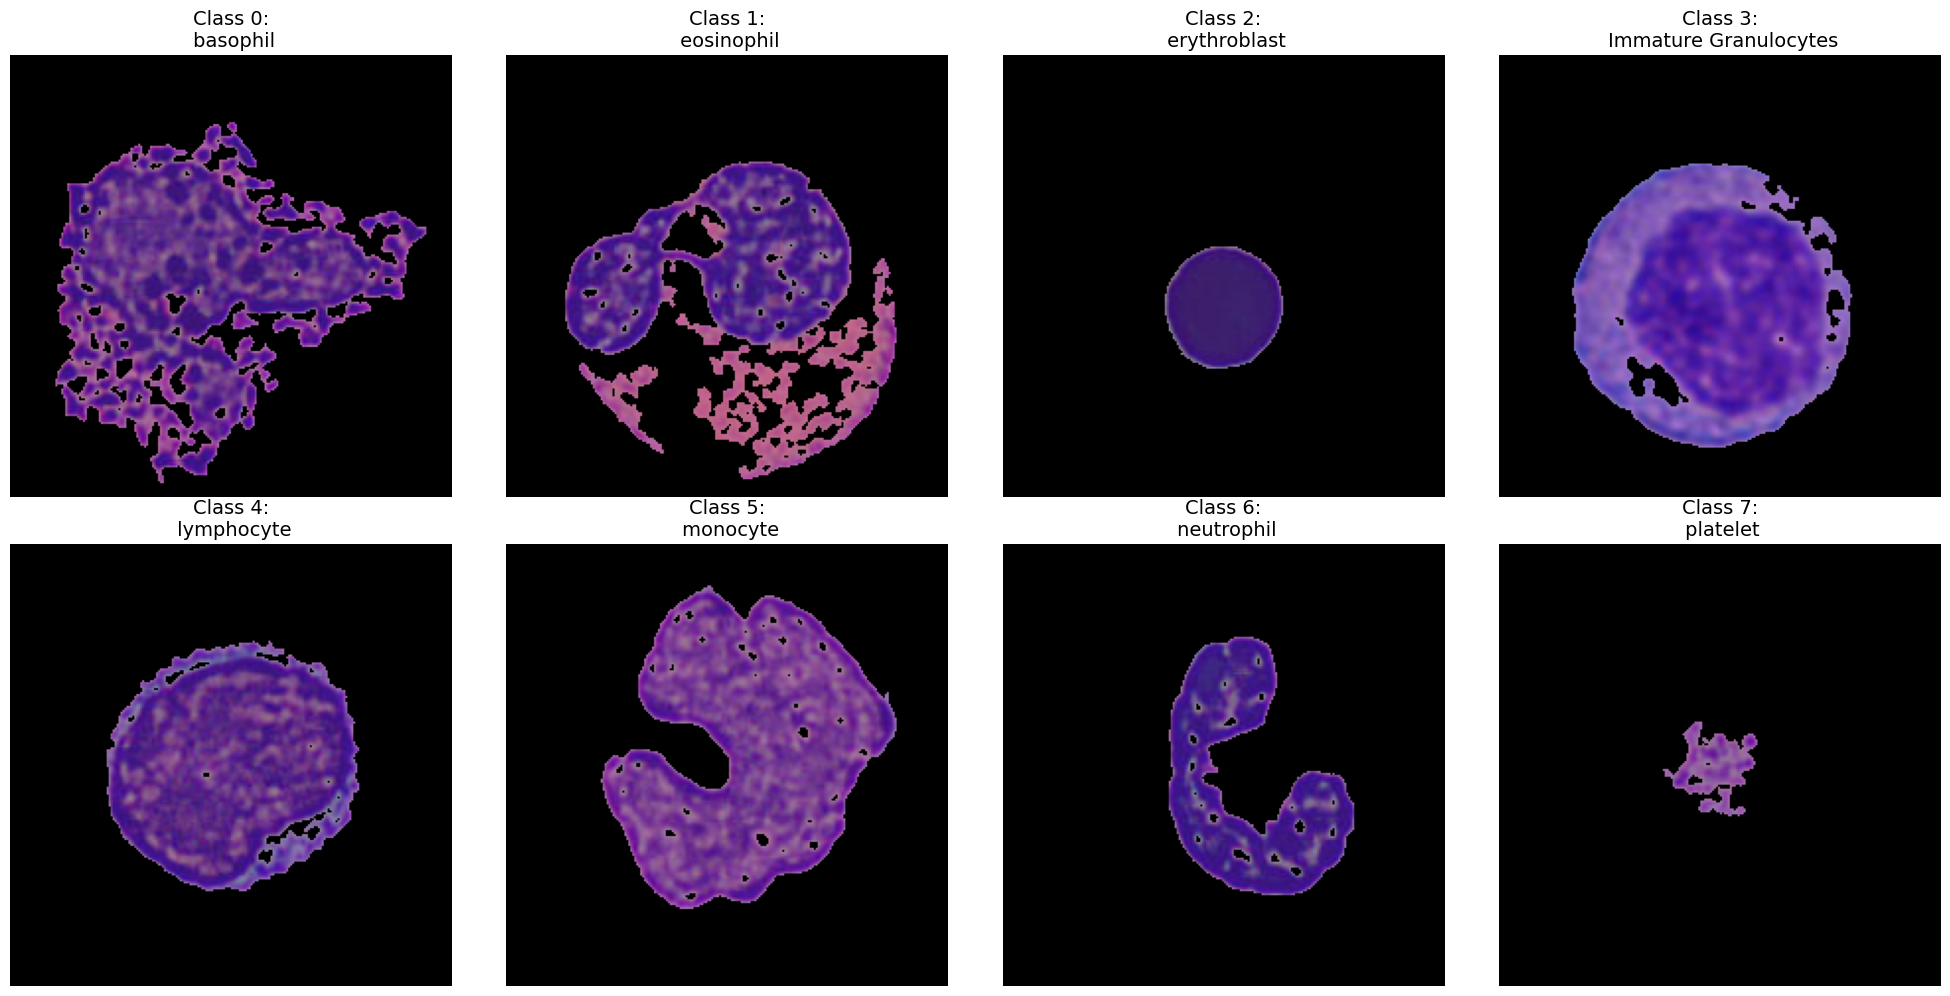

In [31]:
def show_one_image_per_class(dataset, n_classes, class_labels):
    """Randomly show one pre-processed image per class"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            axes[class_idx].imshow(random_img)
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show one example image from the preprocessed training dataset for each class
show_one_image_per_class(train_data_preprocessed, n_classes_blood, class_labels_blood)

/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_8998/2280269436.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


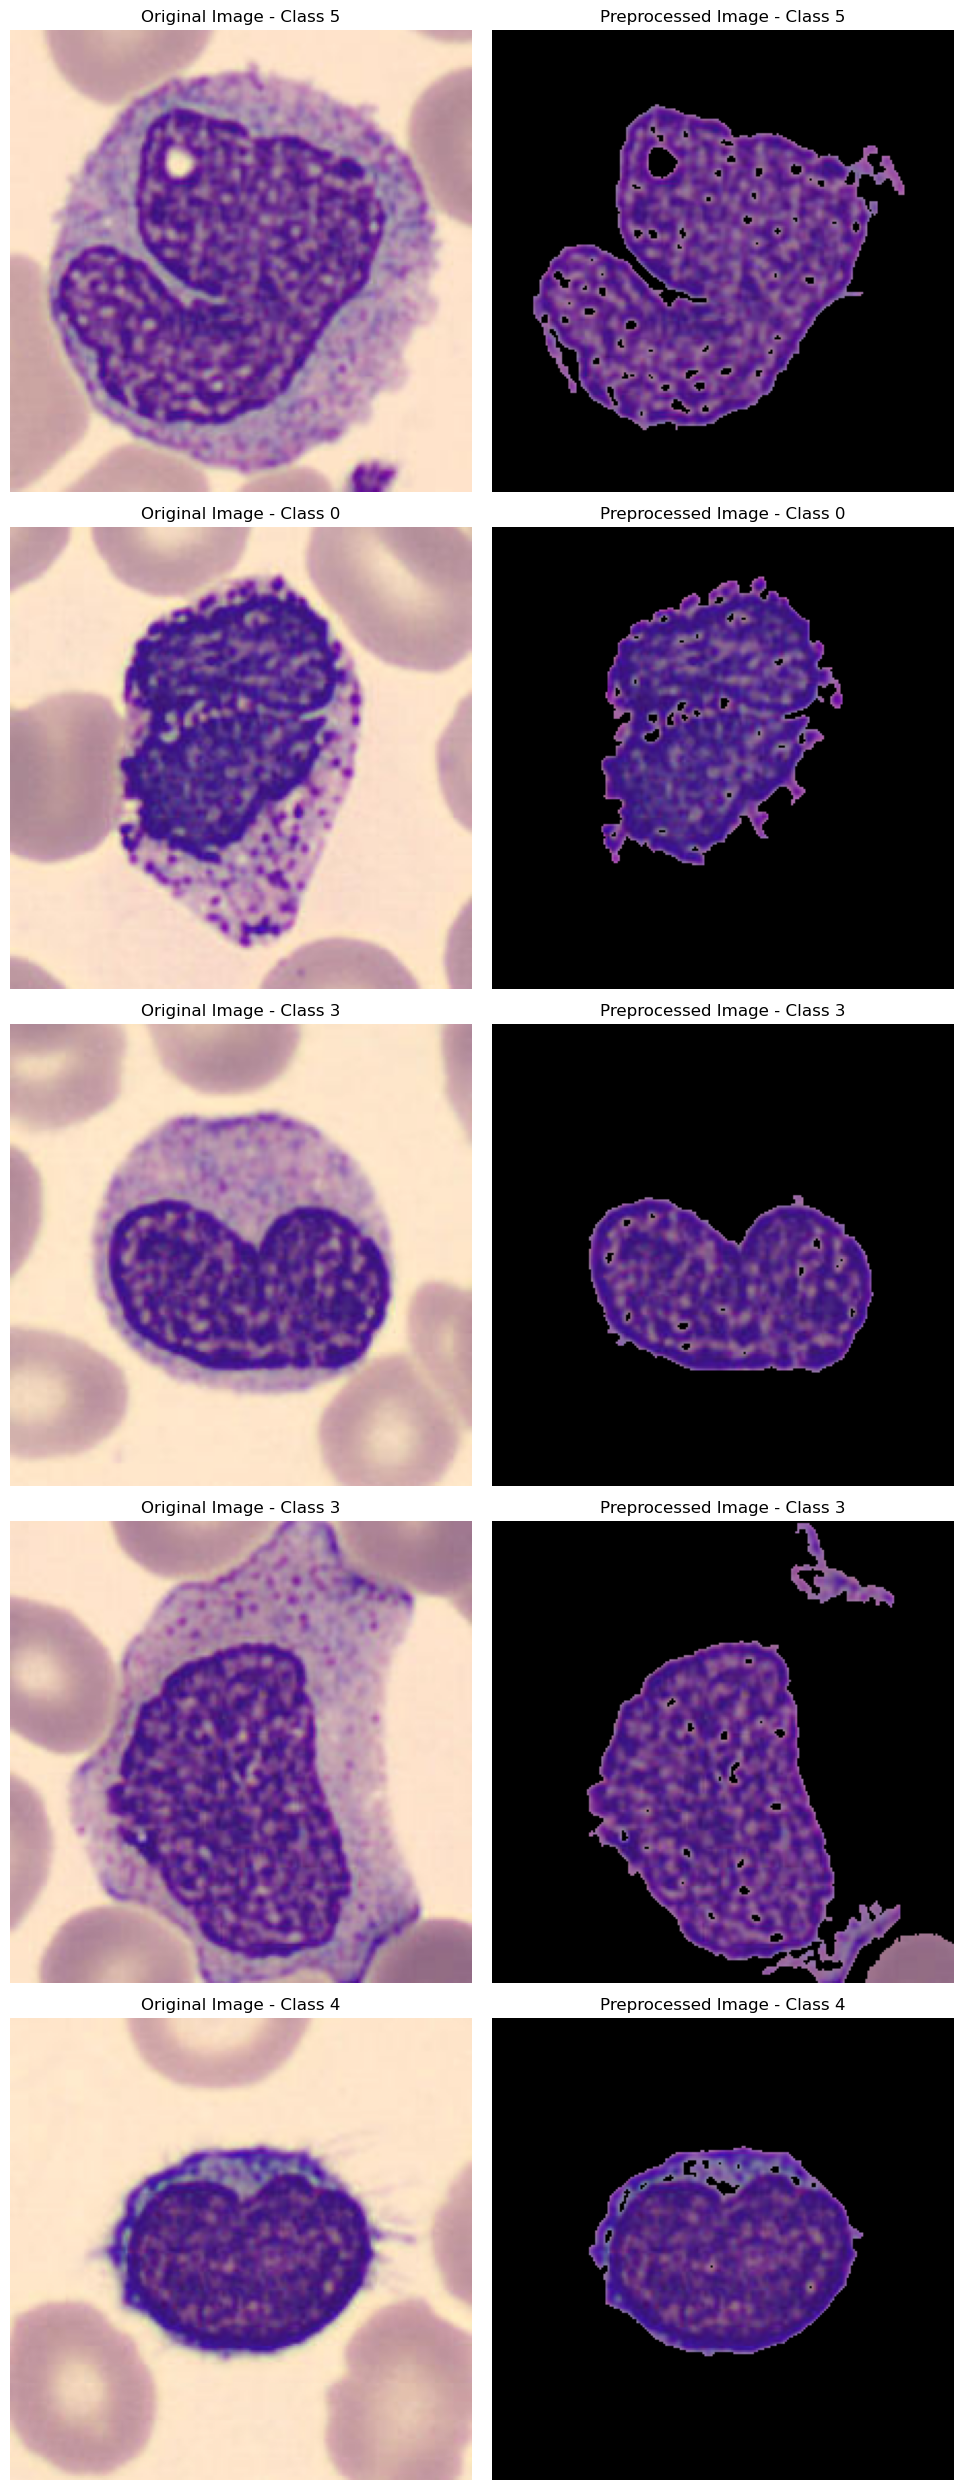

In [32]:
# Show comparison for 5 random images from the training dataset
show_comparison(train_data, n_images=5)

# Feature Engineering
- Simple Feature: Edges
    - Edge detection can highlight the boundaries of cells, which is crucial for distinguishing between different types of blood cells based on their shape and size. Using edge detection algorithms can provide valuable information about cell morphology.

- Simple Feature: Color Histograms
    - Color histograms represent the distribution of colors in an image and can help differentiate between cell types based on color variations. This is particularly useful for identifying cell types like eosinophils and basophils, which have distinct color characteristics.

- Complex Feature: Texture Analysis
    - Texture analysis involves examining the surface characteristics of cells, which can be quantified using methods like Local Binary Patterns (LBP) or Gray Level Co-occurrence Matrix (GLCM). Texture features can provide deeper insights into the cell structure, helping to distinguish between similar looking cell types.


## Edge Detection

In [51]:
def extract_edge_features(image):
    edges = cv2.Canny((rgb2gray(image) * 255).astype(np.uint8), 100, 200)
    return edges.flatten()

In [52]:
def show_edge_detection(dataset, n_images=5):
    """Show edge detection results for a number of images"""
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

    for i in range(n_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        preprocessed_img = preprocess_image(np.array(img))
        edges = cv2.Canny((rgb2gray(img) * 255).astype(np.uint8), 100, 200)

        axes[i, 0].imshow(preprocessed_img)
        axes[i, 0].set_title(f"Preprocessed Image - Class {int(label)}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(edges, cmap='gray')
        axes[i, 1].set_title(f"Edges - Class {int(label)}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_8998/2280269436.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


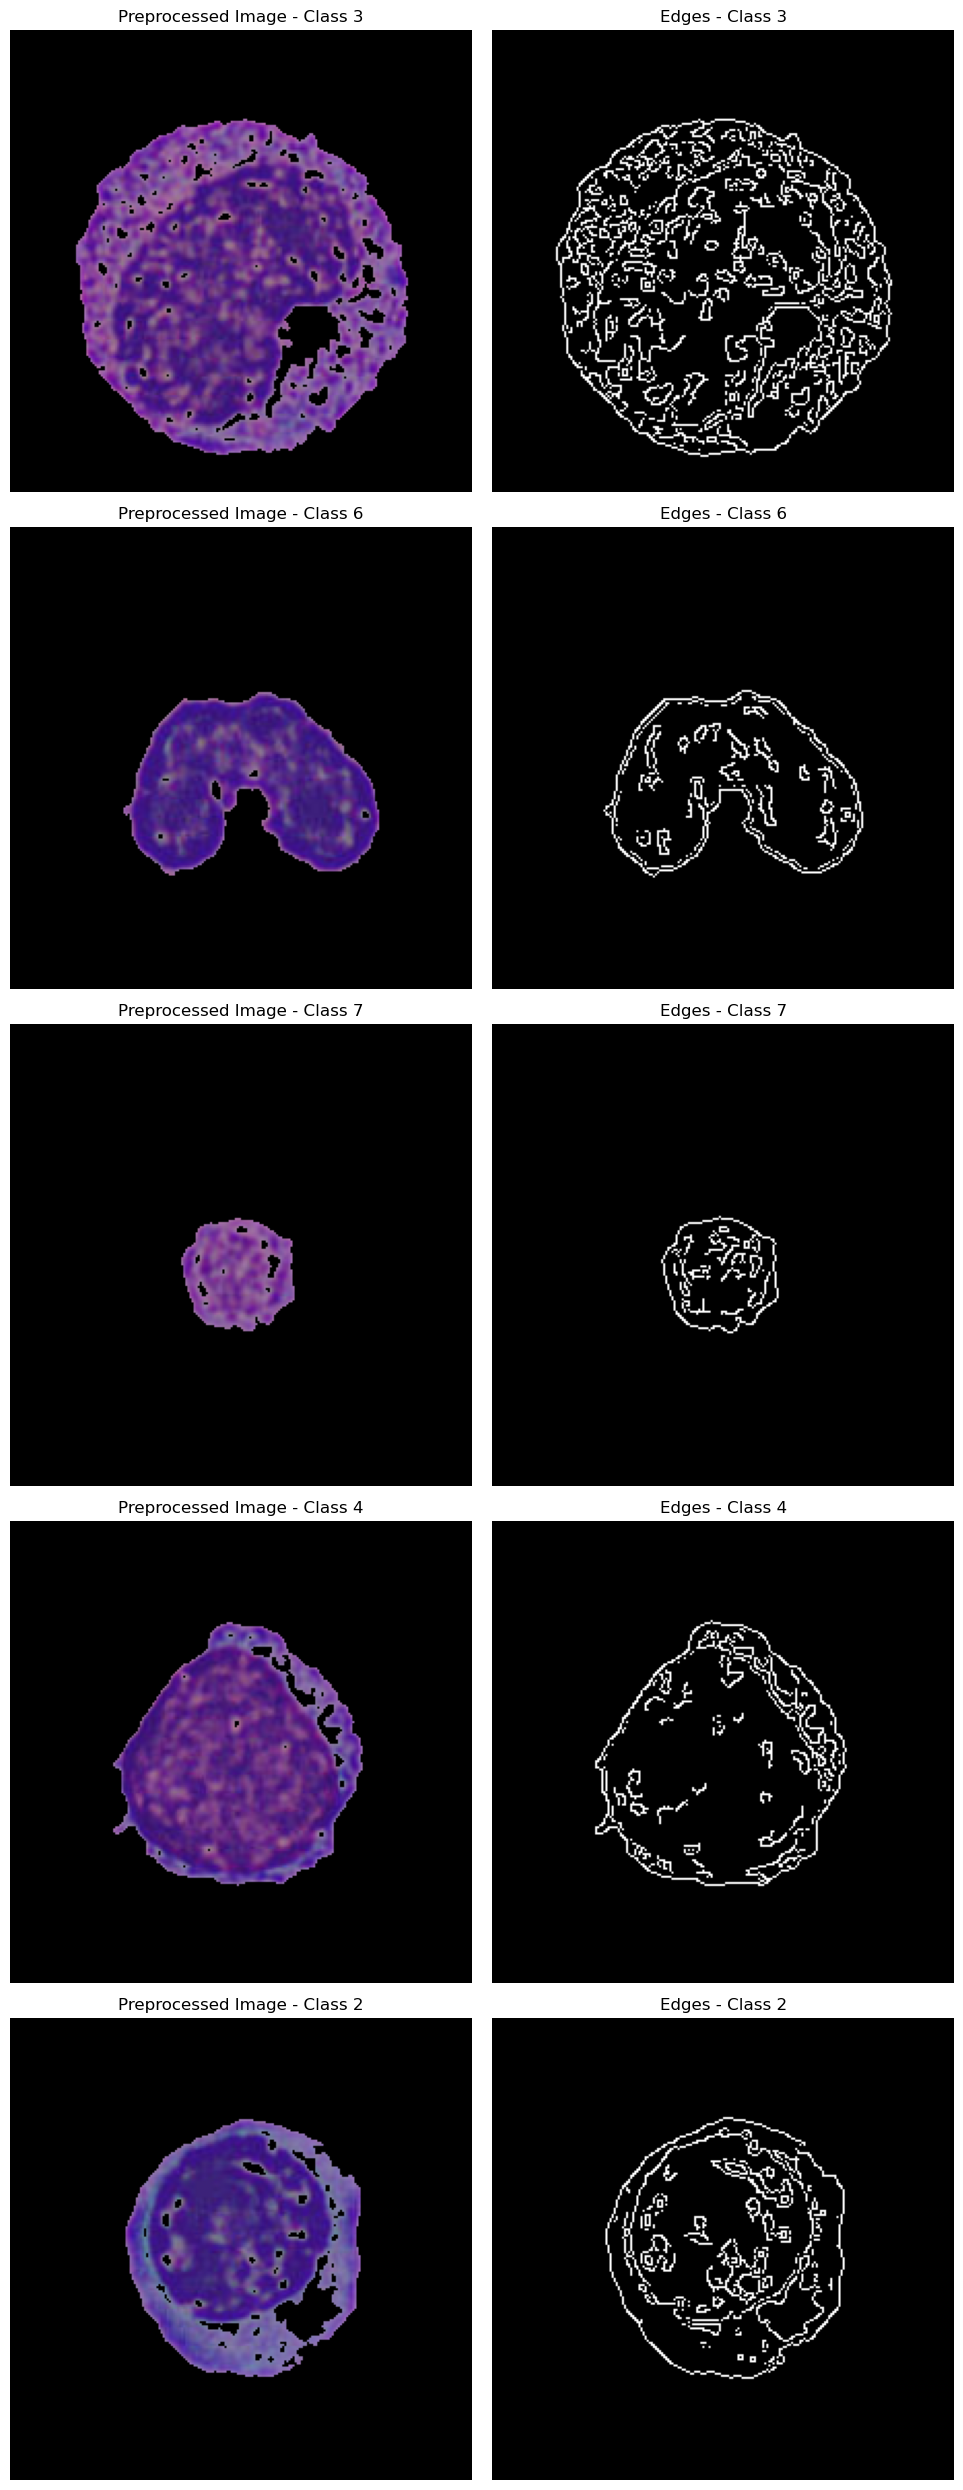

In [53]:
show_edge_detection(train_data_preprocessed)

## Color Histograms

In [73]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Convert PIL Image to NumPy array
    image = np.array(image)
    
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Compute the color histogram
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    
    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    
    return hist

In [67]:
def show_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    
    plt.figure(figsize=(8, 6))
    plt.title('Color Histogram')
    plt.xlabel('Bins')
    plt.ylabel('# of Pixels')
    plt.plot(hist)
    plt.xlim([0, bins[0]*bins[1]*bins[2]])
    plt.show()


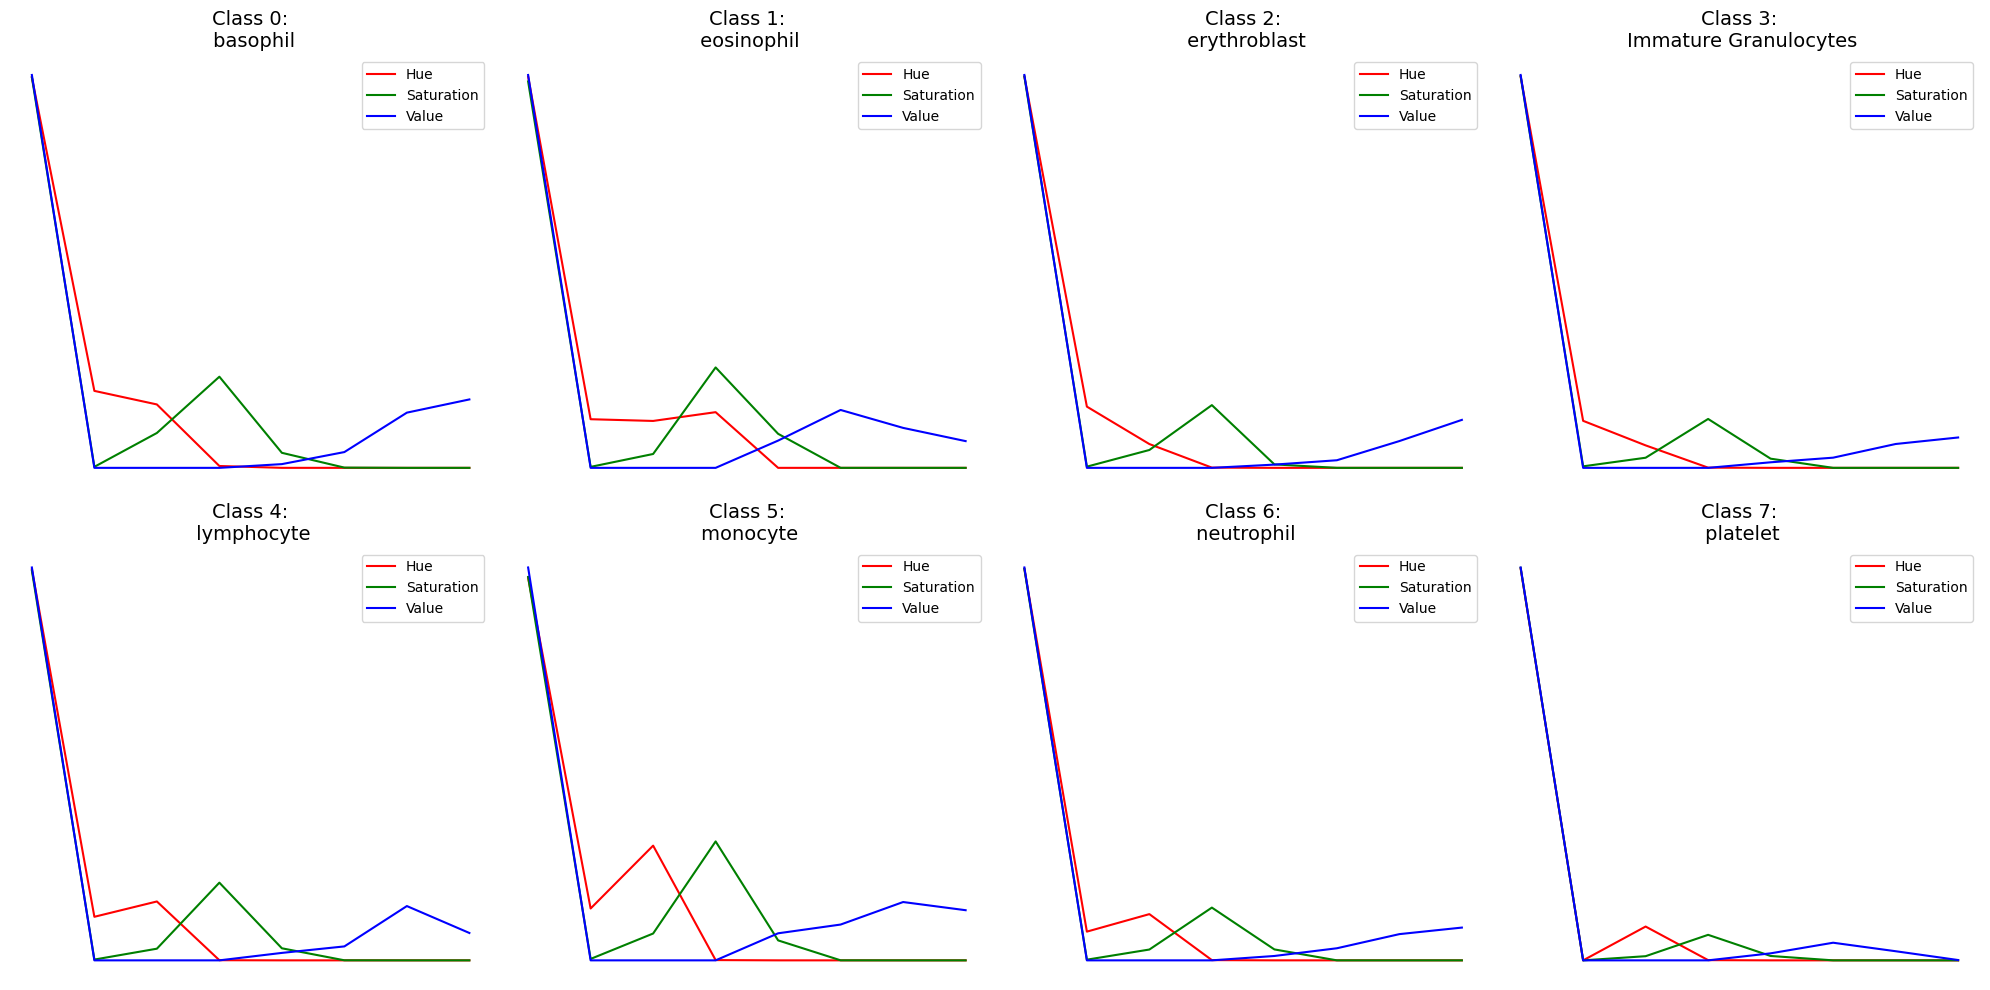

In [83]:
def show_color_histograms(dataset, n_classes, class_labels, bins=(8, 8, 8)):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            hsv = cv2.cvtColor((random_img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)

            # Compute the histograms for each channel
            hist_hue = cv2.calcHist([hsv], [0], None, [bins[0]], [0, 180])
            hist_saturation = cv2.calcHist([hsv], [1], None, [bins[1]], [0, 256])
            hist_value = cv2.calcHist([hsv], [2], None, [bins[2]], [0, 256])

            # Normalize the histograms
            hist_hue = cv2.normalize(hist_hue, hist_hue).flatten()
            hist_saturation = cv2.normalize(hist_saturation, hist_saturation).flatten()
            hist_value = cv2.normalize(hist_value, hist_value).flatten()

            # Plot histograms
            axes[class_idx].plot(hist_hue, color='r', label='Hue')
            axes[class_idx].plot(hist_saturation, color='g', label='Saturation')
            axes[class_idx].plot(hist_value, color='b', label='Value')
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')
            axes[class_idx].legend()

    plt.tight_layout()
    plt.show()

# Show color histograms for each class
show_color_histograms(train_data_preprocessed, n_classes_blood, class_labels_blood)


# Create Feature Vector

In [75]:
def create_feature_vectors(dataset, feature_extractors):
    """Function to create feature vectors from the dataset"""
    feature_vectors = []
    labels = []
    for img, label in dataset:
        features = []
        for extractor in feature_extractors:
            features.extend(extractor(img))
        feature_vectors.append(features)
        labels.append(label)
    return np.array(feature_vectors), np.array(labels)

In [76]:
# Define the combined feature extractor
def extract_combined_features(image):
    edge_features = extract_edge_features(image)
    color_histogram = extract_color_histogram(image)
    return np.concatenate([edge_features, color_histogram])

In [77]:
# Extract features from the preprocessed datasets
X_train, y_train = create_feature_vectors(train_data, [extract_edge_features, extract_color_histogram])
X_val, y_val = create_feature_vectors(val_data, [extract_edge_features, extract_color_histogram])
X_test, y_test = create_feature_vectors(test_data, [extract_edge_features, extract_color_histogram])


# Dimensionality Reduction and Scale Data

In [78]:
# Apply PCA to reduce dimensionality
n_components = 50  # Adjust based on trade-off between speed and accuracy
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Build Models
- Use Logistic Regression as a baseline

In [79]:
# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_pca, y_train)

# Evaluate the model
y_train_pred = log_reg.predict(X_train_pca)
y_val_pred = log_reg.predict(X_val_pca)
y_test_pred = log_reg.predict(X_test_pca)

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accuracy: 0.6038130278451376
Validation accuracy: 0.6063084112149533
Test accuracy: 0.6121017246419176
Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.49      0.30      0.37       244
           eosinophil       0.55      0.68      0.61       624
         erythroblast       0.64      0.70      0.67       311
Immature Granulocytes       0.44      0.58      0.50       579
           lymphocyte       0.77      0.79      0.78       243
             monocyte       0.43      0.12      0.19       284
           neutrophil       0.64      0.56      0.59       666
             platelet       0.92      0.96      0.94       470

             accuracy                           0.61      3421
            macro avg       0.61      0.58      0.58      3421
         weighted avg       0.61      0.61      0.60      3421



/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


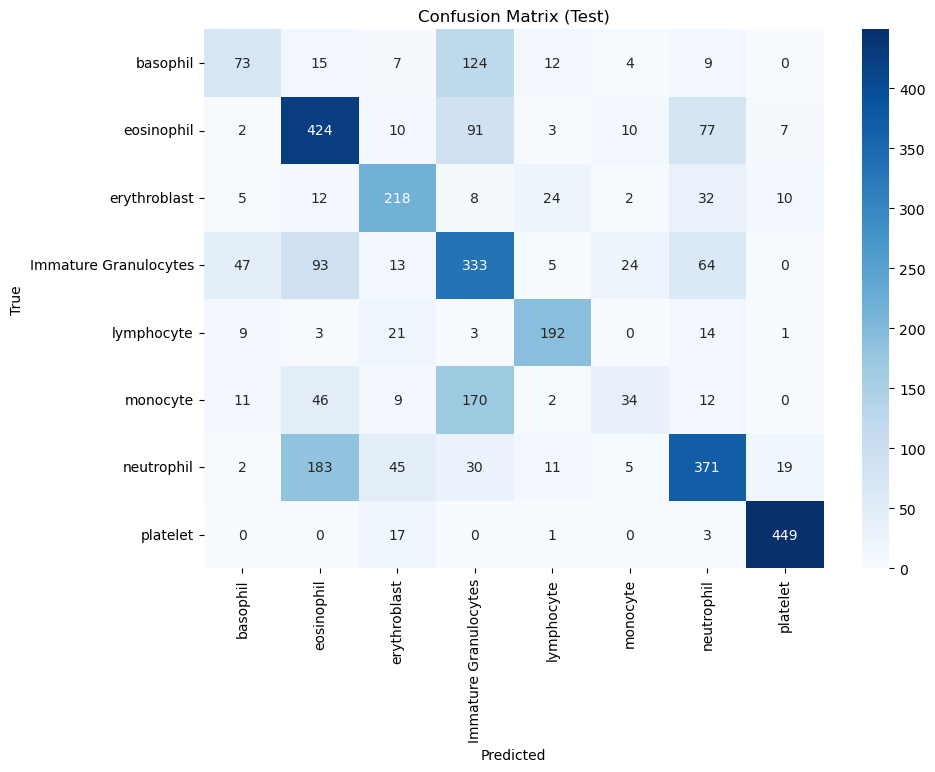

In [80]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Plot confusion matrix for test data
plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test)')

# Results

## Baseline: Logistic Regression

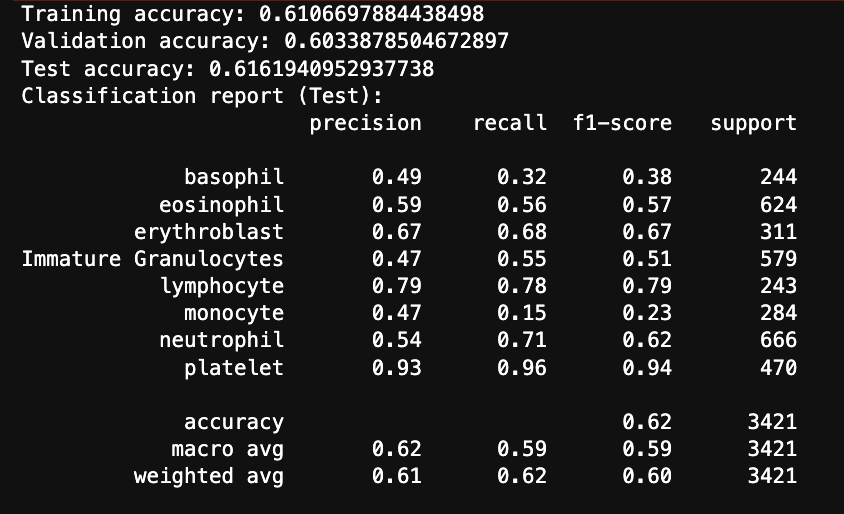

# Next Steps

- Explore Additional Features: Since color histograms didn't add significant value, consider exploring other features such as texture analysis (e.g., Local Binary Patterns, Gray Level Co-occurrence Matrix) or more advanced shape descriptors.

- Feature Selection: Perform feature selection techniques to identify the most important features for your classification task. This can help reduce the dimensionality and improve model performance.